In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans

In [12]:

# Simulating time series data for 3 hospitals
np.random.seed(0)  # For reproducible results
time_points = 50

# Hospital 1 data
hospital_1 = pd.DataFrame({
    'admissions': np.random.poisson(10, time_points),
    'length_of_stay': np.random.normal(5, 1, time_points),
    'occupancy_rate': np.random.uniform(0.6, 1.0, time_points)
})

# Hospital 2 data
hospital_2 = pd.DataFrame({
    'admissions': np.random.poisson(15, time_points),
    'length_of_stay': np.random.normal(6, 1.5, time_points),
    'occupancy_rate': np.random.uniform(0.5, 0.9, time_points)
})

# Hospital 3 data
hospital_3 = pd.DataFrame({
    'admissions': np.random.poisson(12, time_points),
    'length_of_stay': np.random.normal(4, 1.2, time_points),
    'occupancy_rate': np.random.uniform(0.4, 0.8, time_points)
})

print(hospital_1)

# Combine the hospital data into a list
hospital_data = [hospital_1, hospital_2, hospital_3]


# DTW clustering
# Convert the list of DataFrames to a 3D NumPy array
hospital_data_series = np.array(hospital_data)

# Apply DTW-based KMeans clustering
km_dtw = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=0)
labels = km_dtw.fit_predict(hospital_data_series)

# Output the cluster labels for each hospital
print("Cluster labels for each hospital (DTW):", labels)


# Feature extraction and KMeans clustering with PCA
# Placeholder for feature extraction
hospital_features = []

for df in hospital_data:
    # Extract features for each time series in the DataFrame
    features = []
    
    for column in df.columns:
        # Calculate summary statistics for each time series
        mean = df[column].mean()
        std_dev = df[column].std()
        trend = df[column].diff().mean()  # Simple measure of trend
        min = df[column].min()
        max = df[column].max()
        range_val = max - min
        median = df[column].median()
        sum = df[column].sum()

        
        # Append these features to the list for the current hospital
        features.extend([mean, std_dev, trend, min, max, range_val, median, sum])
    
    # Add the features for the current hospital to the hospital_features list
    hospital_features.append(features)

# Convert the features list to a DataFrame
features_df = pd.DataFrame(hospital_features, columns=[
    'admissions_mean', 'admissions_std', 'admissions_trend',
    'admissions_min', 'admissions_max', 'admissions_range',
    'admissions_median', 'admissions_sum',
    'length_of_stay_mean', 'length_of_stay_std', 'length_of_stay_trend',
    'length_of_stay_min', 'length_of_stay_max', 'length_of_stay_range',
    'length_of_stay_median', 'length_of_stay_sum',
    'occupancy_rate_mean', 'occupancy_rate_std', 'occupancy_rate_trend',
    'occupancy_rate_min', 'occupancy_rate_max', 'occupancy_rate_range',
    'occupancy_rate_median', 'occupancy_rate_sum'
])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

# Using PCA
pca = PCA(n_components=2)
scaled_data = pca.fit_transform(features_scaled)

# Find the best number of clusters
biggest = (0, 0)
for n_cluster in range(2, len(hospital_data)):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    if score > biggest[1]:
        biggest = (n_cluster, score)
    #print(n_cluster, score)
#print(biggest)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=biggest[0], random_state=0)
labels = kmeans.fit_predict(scaled_data)

# Output the clusters
features_df['Cluster'] = labels
#print(features_df)


    admissions  length_of_stay  occupancy_rate
0           10        3.826877        0.623212
1           11        6.943621        0.773767
2            9        4.586381        0.724718
3            9        4.252545        0.878537
4           18        6.922942        0.751101
5           13        6.480515        0.671841
6            4        6.867559        0.609871
7           10        5.906045        0.626900
8           10        4.138774        0.871757
9            8        6.910065        0.781479
10          10        4.731997        0.814632
11          11        5.802456        0.958669
12          16        5.947252        0.996136
13           9        4.844990        0.686759
14          12        5.614079        0.865231
15          12        5.922207        0.705329
16           7        5.376426        0.608260
17           8        3.900599        0.903351
18          11        5.298238        0.728007
19           7        6.326386        0.753386
20          1

In [13]:
features_df

,admissions_mean,admissions_std,admissions_trend,admissions_min,admissions_max,admissions_range,admissions_median,admissions_sum,length_of_stay_mean,length_of_stay_std,...,length_of_stay_sum,occupancy_rate_mean,occupancy_rate_std,occupancy_rate_trend,occupancy_rate_min,occupancy_rate_max,occupancy_rate_range,occupancy_rate_median,occupancy_rate_sum,Cluster
0,10.44,2.843970,0.040816,4,18,14,10.5,522,5.253327,1.006205,...,262.666346,0.783060,0.112123,0.001022,0.608260,0.996136,0.387875,0.771820,39.152992,1
1,14.98,3.722464,0.163265,7,25,18,15.0,749,5.795445,1.498800,...,289.772253,0.722658,0.126772,0.001521,0.518403,0.897760,0.379357,0.709855,36.132894,0
2,11.94,3.655636,0.081633,3,22,19,12.0,597,3.952999,1.371942,...,197.649966,0.566630,0.117327,-0.002821,0.401544,0.794940,0.393395,0.547663,28.331503,1


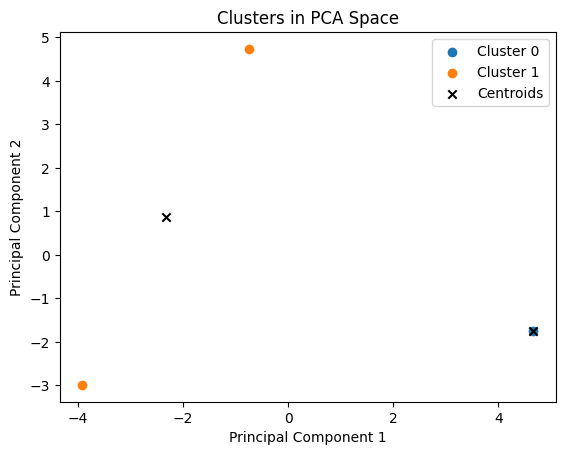

In [14]:
import matplotlib.pyplot as plt

for cluster in range(kmeans.n_clusters):
    cluster_points = scaled_data[kmeans.labels_ == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

# Plot the cluster centroids as black 'X' markers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            color='black', marker='x', label='Centroids')

plt.title("Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# Display the plot
plt.show()